In [7]:
import torch
import matplotlib.pyplot as plt
import torch
from torch.optim import LBFGS
import time
import numpy as np
import os
import scipy.special  


device = torch.device('cuda')  # Usamos CPU para este ejemplo

In [8]:
# Definir la función legendre de forma vectorizada
def legendre(n, x, lb, ub):
    x = 2 * (x - lb) / (ub - lb) - 1    
    P0 = torch.ones_like(x)
    if n == 0:
        return P0
    P1 = x
    if n == 1:
        return P1
    for _ in range(2, n + 1):
        P0, P1 = P1, ((2 * _ - 1) * x * P1 - (_ - 1) * P0) / _
    return P1
 
#Evaluación de la serie de Legendre 2-D utilizando broadcasting
def evaluate_legendre_series(coefficients, leg_x, leg_y):
    n = int(torch.sqrt(torch.tensor(coefficients.numel()).float()))  # Convert to tensor before sqrt
    coefficients = coefficients.view(n, n)
    # Utilizando broadcasting para calcular la serie de Legendre
    result = torch.sum(coefficients[:, :, None, None] * leg_x[:, None, :, :] * leg_y[None, :, :, :], dim=(0, 1))
    return result.unsqueeze(-1) 

In [9]:
# Precomputar leg_x y leg_y una vez
start_precompute = time.time()

# Elige una suposición inicial para los coeficientes
N = 8  # Grado máximo de los polinomios de Legendre
initial_guess = torch.zeros(N*N, requires_grad=True, dtype=torch.float64, device=device)  # Suposición inicial para los coeficientes
lb, ub = 0, 1  # Límites de integración
# Datos de entrada para la función y los polinomios de Legendre
X1_grid, X2_grid = torch.meshgrid(torch.linspace(0, 1, 100, dtype=torch.float64, device=device), torch.linspace(0, 1, 100, dtype=torch.float64, device=device))
X1=X1_grid.unsqueeze(-1)
X2=X2_grid.unsqueeze(-1)

n = int(torch.sqrt(torch.tensor(initial_guess.numel(), device=device)))
leg_x = torch.stack([legendre(i, X1_grid, lb, ub).to(device).double() for i in range(n)], dim=0)
leg_y = torch.stack([legendre(j, X2_grid, lb, ub).to(device).double() for j in range(n)], dim=0)

end_precompute = time.time()
time_precompute = end_precompute - start_precompute
print(f"Tiempo de precomputación de Legendre polynomials: {time_precompute:.4f} segundos")

Tiempo de precomputación de Legendre polynomials: 0.0070 segundos


Loss: 0.2787839941956037
Loss: 0.11071667324301143
Loss: 0.037601736811577795
Loss: 0.022149062847332764
Loss: 0.004634798468390033
Loss: 0.002556004462585105
Loss: 0.0007251532059725954
Loss: 0.00012753595943404194
Loss: 1.4306534405017185e-05
Loss: 1.0204067029240136e-05
Loss: 7.34997610405678e-06
Loss: 2.898897557214976e-06
Loss: 3.7150450571599933e-07
Loss: 1.1131826117653536e-07
Loss: 5.534104468941487e-08
Loss: 4.704436855081037e-08
Loss: 2.1553170593555144e-08
Loss: 8.447106219225431e-09
Loss: 2.2913037224652296e-09
Loss: 7.270711833018457e-10
Loss: 5.563475823930756e-10
Loss: 4.437461981096598e-10
Loss: 3.5551744164322055e-10
Loss: 2.860615482602284e-10
Loss: 2.3121680267139333e-10
Loss: 1.8776996645457683e-10
Loss: 1.5323358801776404e-10
Loss: 1.256792302042541e-10
Loss: 1.0360952608730906e-10
Loss: 8.585987212697172e-11
Loss: 7.152283472973451e-11
Loss: 5.988997541541669e-11
Loss: 5.040704191373699e-11
Loss: 4.263942186138987e-11
Loss: 3.624548164052662e-11
Loss: 3.0955968087

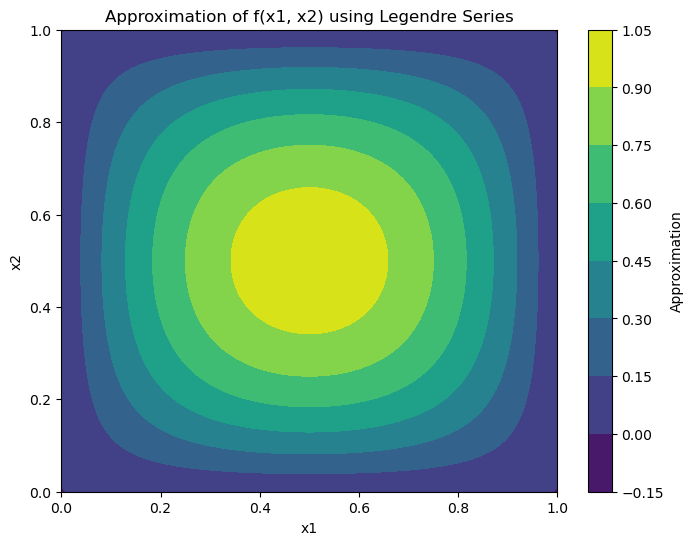

In [10]:
# Define la función para la cual quieres calcular los coeficientes de la serie de Legendre
def f(x1, x2):
    return 16*(1 - x1) * x1 * (1 - x2) * x2
    #return x1*x2*(1-x1)*(1-x2)*torch.exp(x1-x2)

# Define la función de error
def error_function(coefficients, leg_x, leg_y):
    approximation = evaluate_legendre_series(coefficients, leg_x, leg_y)
    #print(approximation.shape)
    error = torch.mean((f(X1, X2) - approximation) ** 2)
    return error

# Usar una función de optimización para minimizar la función de error con respecto a los coeficientes
 
optimizer = torch.optim.LBFGS([initial_guess],
                                lr=1,
                                max_iter=50_000,
                                max_eval=50_000,
                                tolerance_grad=1e-9,
                                history_size=100,
                                tolerance_change=1.0 * np.finfo(float).eps,
                                line_search_fn=None)

def closure():
    optimizer.zero_grad()
    loss = error_function(initial_guess, leg_x, leg_y)
    print(f"Loss: {loss.item()}")
    loss.backward()
    return loss

# Realizar pasos de optimización
start_optimization = time.time()
optimizer.step(closure)
end_optimization = time.time()

# Coeficientes óptimos encontrados
optimal_coefficients = initial_guess.detach()

# Evaluar la aproximación de la serie de Legendre
start_evaluation = time.time()
approximation = evaluate_legendre_series(optimal_coefficients, leg_x, leg_y)
end_evaluation = time.time()

# Medir el tiempo de optimización y evaluación
time_optimization = end_optimization - start_optimization
time_evaluation = end_evaluation - start_evaluation

print(f"Tiempo de optimización: {time_optimization:.4f} segundos")
print(f"Tiempo de evaluación: {time_evaluation:.4f} segundos")

# Graficar el resultado usando contourf
plt.figure(figsize=(8, 6))
plt.contourf(X1.cpu().numpy().reshape(X1_grid.shape), X2.cpu().numpy().reshape(X1_grid.shape), approximation.cpu().numpy().reshape(X1_grid.shape), cmap='viridis')
plt.colorbar(label='Approximation')
plt.title('Approximation of f(x1, x2) using Legendre Series')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

In [11]:
# Calcular el error en la predicción
prediction_error = error_function(optimal_coefficients, leg_x, leg_y)

print(f"Error en la predicción: {prediction_error.item()}")

Error en la predicción: 5.1166308731061204e-15


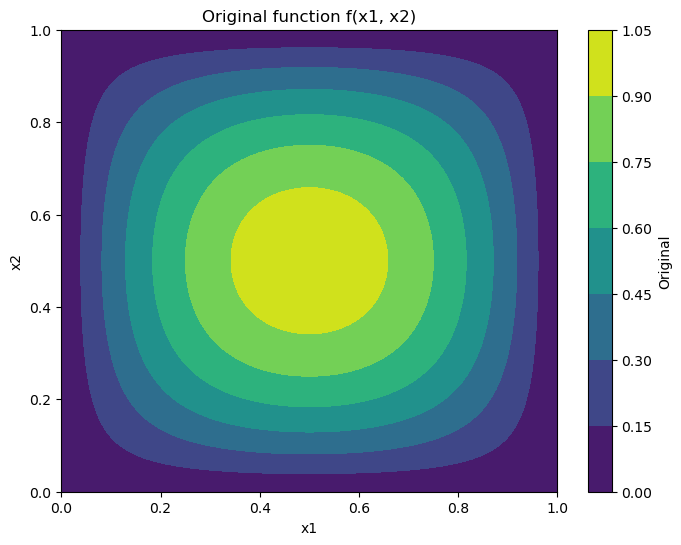

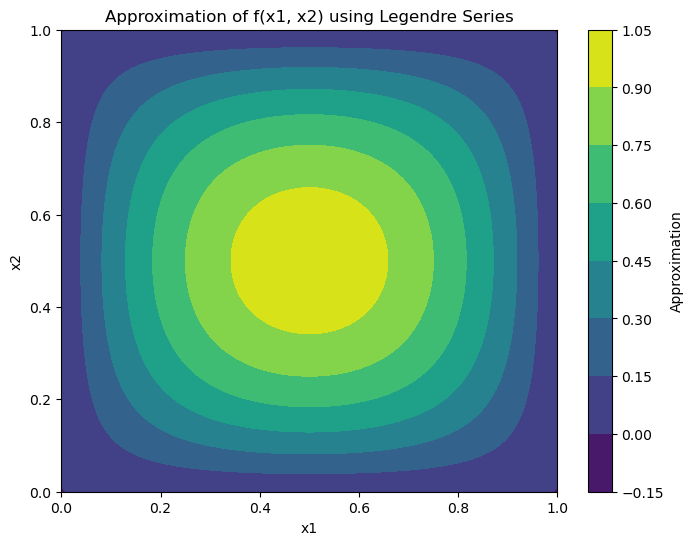

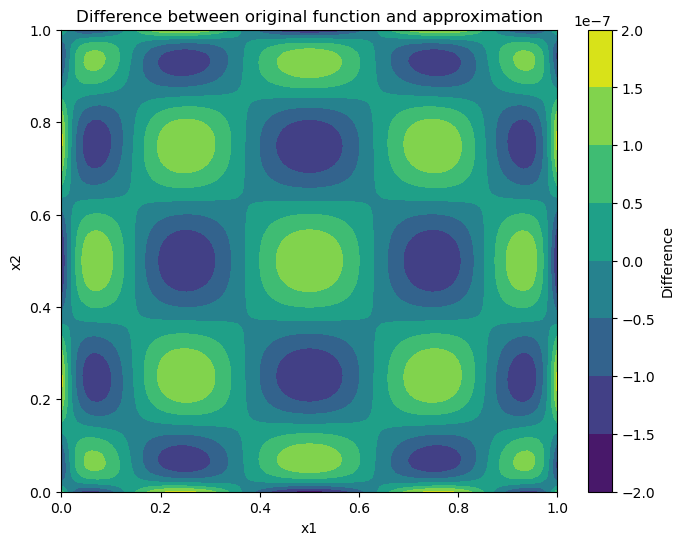

In [12]:
# Calcular la función original
original = f(X1, X2)

# Calcular la diferencia entre la función original y la aproximación
difference = original - approximation

# Graficar la función original
plt.figure(figsize=(8, 6))
plt.contourf(X1.cpu().numpy().reshape(X1_grid.shape), X2.cpu().numpy().reshape(X1_grid.shape), original.cpu().numpy().reshape(X1_grid.shape), cmap='viridis')
plt.colorbar(label='Original')
plt.title('Original function f(x1, x2)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Graficar la aproximación
plt.figure(figsize=(8, 6))
plt.contourf(X1.cpu().numpy().reshape(X1_grid.shape), X2.cpu().numpy().reshape(X1_grid.shape), approximation.cpu().numpy().reshape(X1_grid.shape), cmap='viridis')
plt.colorbar(label='Approximation')
plt.title('Approximation of f(x1, x2) using Legendre Series')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Graficar la diferencia
plt.figure(figsize=(8, 6))
plt.contourf(X1.cpu().numpy().reshape(X1_grid.shape), X2.cpu().numpy().reshape(X1_grid.shape), difference.cpu().numpy().reshape(X1_grid.shape), cmap='viridis')
plt.colorbar(label='Difference')
plt.title('Difference between original function and approximation')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()